# Fraud Activity Detection

Every day, Intuit’s Strategic Risk Group assigns a fraud risk score to all of our payments customers.  Our customers are all merchants who accept credit card payments for their business.  Some of the applications we receive to process payments are from people trying to commit fraud by pretending to be legitimate merchants.  Typically, these fraudulent merchants will use stolen credit cards to funnel money into their account.

The zipped sample data contains a few of the types of data we use in our assessment for fraud.  All of the merchants in the attached files have made mobile credit card payment transactions at least once.  Some of these merchants turned out later to be fraudulent. 

The zipped file includes three tables from merchants who opened an account between 2013 and July 2015.  For the last 3 weeks of data (July 10, 2015 to July 31, 2015) there is no information regarding whether the merchant was closed for fraud.  For all accounts opened before July 10, information on when the account was closed for fraud is provided.



## Goal
Based on DateClosed by Fraud is empty or not as a fraud target and build a machine learning model to detect fraud activity. 

# Summary

### Part I: Steps and explaination

1. Start project: Take a look at data structure, determine how to combine table, and which field to use as target value. 
2. Feature Enginering and Data Clean:
    1. time diffrence between account open and first transaction
    2. hour of day, week of the year and day the week from time variables
    3. wether IP_Address_organization is same as Pierced_IP_address_organization
    4. same as No.C if IP_Address_Location matches Pierced_IP_address_location
    5. wether application address match ip and pierced ip
    6. wether application area code matches ip and pierced ip
3. Visualization data and valuate features we extract out is necessary to put in model. 
4. Oversampling/Undersampling imbalanced data. 
    1. I tried to model without oversampling/undersampling and finally model F1 score is extremely low and out of range I can accept. 
    2. I tried undersampling and it perform very bad. 
    3. I choose to use oversample instead of undersample, and do cross validation on original data while using over-sampled data to do modeling fit. 
5. Modeling and Parameter Pruning:
    1. Using CV to find best model max_depth while prevent overfitting
    2. Using ROC curves and AUC to determine we want to decision tree or random forest
    3. ROC also can help to select best cutoff threshold 
6. Using best model to fit and predict. 
    1. Use predict_proba export the chance of a merchant is risky or not. 
    2. Rank them to genrate top 100 risky merchant




### Part II : Steps and explaination
1. I use function to extract decision path from a simplified decision tree and build a dot file.(Note: performance of simplified decision is extremly low)
2. Visualization decision tree by use graphviz package. 
3. Generate code for rule logic. 
4. Build SQL Query from rule logic.

### Something I want to try but not have time

1. Try use Adaboost decision Tree: For my own experience, Adaboost performance better than decision tree/ ramdom forest especially on this project sample size. (RF reduce variance, Adaboost reduce error)
2. In Parameter search I did not have chance to search the full grid and find best model, theoretically all emsemble methods will perform bettern than single trees but require more time to find best parameter. 
3. Other non-tree related model, such as logistic regression. 

## Part I 

### Read in data and take look at data structure

We want to view how data structure looks like, and think about what kind of feature can be used in future predictions. 

In [98]:
# Importing a few necessary libraries
import numpy as np
import math  as math
import pandas as pd
import re
import sys

from IPython.display import display

try: 
    application_data = pd.read_csv('../data/training exercise data - application.csv')
    first_transaction_data = pd.read_csv('../data/training exercise data - first transaction.csv')    
    fraud_target = pd.read_csv('../data/training exercise data - fraud target.csv')    
    print "Import Data Succesful"
except:
    print "Unexpected error:", sys.exc_info()[0]

Import Data Succesful


In [99]:
#combine data 
fraud_data = pd.merge(application_data,first_transaction_data, on = 'merchantidentifier')
fraud_data = pd.merge(fraud_data,fraud_target, on = 'merchantidentifier')

display(fraud_data.head())

,merchantidentifier,IP_Address_organization,IP_Address_Location,Pierced_IP_address_organization,Pierced_IP_address_location,timezone_differencefromGMT_using_application_device,date_account_opened,state_from_application_address,AreaCodeState,first_transaction_time,first_transaction_amount,dateclosedforfraud,Flag_for_data_with_fraud_outcomes
0,19040311,AT&T U-VERSE,TEXAS,AT&T U-VERSE,TEXAS,360.0,2013-08-15,TX,TX,2013-09-03 15:16:23,1800.00,NaN,1
1,19041453,PAUL BUNYAN TELEPHONE,MINNESOTA,PAUL BUNYAN TELEPHONE,MINNESOTA,360.0,2013-08-20,MN,MN,2013-09-06 05:33:55,1.00,NaN,1
2,19083361,PARK PLAZA,WASHINGTON,PARK PLAZA,WASHINGTON,480.0,2013-08-13,WA,WA,2013-12-19 11:47:29,100.00,NaN,1
3,19085705,AT&T INTERNET SERVICES,CALIFORNIA,AT&T INTERNET SERVICES,CALIFORNIA,480.0,2013-08-14,CA,CA,2013-08-23 09:39:59,1.00,NaN,1
4,19086181,SUDDENLINK COMMUNICATIONS,TEXAS,SUDDENLINK COMMUNICATIONS,TEXAS,360.0,2013-05-03,TX,TX,2013-05-21 11:02:06,237.01,NaN,1


### Data Cleaning/Feature Engineering

1. time diffrence between account open and first transaction
2. hour of day, week of the year and day the week from time variables
3. wether IP_Address_organization is same as Pierced_IP_address_organization
4. same as No.3 if IP_Address_Location matches Pierced_IP_address_location
5. wether application address match ip and pierced ip

In [100]:
#app address ip/pierced ip mathes
from state_code import *

fraud_data["state_from_application_address"].replace(states, inplace=True)
fraud_data['state_from_application_address'] = fraud_data['state_from_application_address'].str.upper()

fraud_data["AreaCodeState"].replace(states, inplace=True)
fraud_data['AreaCodeState'] = fraud_data['AreaCodeState'].str.upper()

print "reformat state finished"

fraud_data['add_area_matches'] = np.where(fraud_data.state_from_application_address == fraud_data.AreaCodeState,
                                           1,0)
fraud_data['pierced_ip_add_matches'] = np.where(fraud_data.Pierced_IP_address_location == fraud_data.state_from_application_address,
                                           1,0)
fraud_data['ip_area_matches'] = np.where(fraud_data.IP_Address_Location == fraud_data.AreaCodeState,
                                           1,0)
fraud_data['pierced_ip_area_matches'] = np.where(fraud_data.Pierced_IP_address_location == fraud_data.AreaCodeState,
                                           1,0)

#Pierced_IP Matches
fraud_data['pierced_ip_org_matches'] = np.where(fraud_data.IP_Address_organization == fraud_data.Pierced_IP_address_organization,
                                           1,0)
fraud_data['pierced_ip_loc_matches'] = np.where(fraud_data.IP_Address_Location == fraud_data.Pierced_IP_address_location,
                                           1,0)

print "Add geographic matches finished"

reformat state finished
Add geographic matches finished


In [101]:
#special area code
fraud_data['is_invalid_area'] = np.where(fraud_data.AreaCodeState == 'INVALID', 1, 0)
fraud_data['is_OA'] = np.where(fraud_data.AreaCodeState == 'OA', 1, 0)
fraud_data['is_tollfree'] = np.where(fraud_data.AreaCodeState == 'TOLLFREE', 1, 0) 

print "special area code extraction finished"

special area code extraction finished


In [102]:
#convert datetime object to datetime format
fraud_data['date_account_opened'] = pd.to_datetime(fraud_data['date_account_opened'])
fraud_data['first_transaction_time'] = pd.to_datetime(fraud_data['first_transaction_time'])
fraud_data['dateclosedforfraud'] = pd.to_datetime(fraud_data['dateclosedforfraud'])

#time diffrence between sign_up and first transaction time
fraud_data['signup_firsttrans_time_diff'] = fraud_data['first_transaction_time'] - fraud_data['date_account_opened']
fraud_data['signup_firsttrans_time_diff'] = fraud_data['signup_firsttrans_time_diff'].dt.seconds

#day of the week
fraud_data['date_account_wd'] = fraud_data['date_account_opened'].dt.dayofweek
fraud_data['firsttrans_time_wd'] = fraud_data['first_transaction_time'].dt.dayofweek

#week of the yr
fraud_data['date_account_wy'] = fraud_data['date_account_opened'].dt.week
fraud_data['firsttrans_time_wy'] = fraud_data['first_transaction_time'].dt.week

#hour of the day
fraud_data['date_account_hr'] = fraud_data['date_account_opened'].dt.hour
fraud_data['firsttrans_time_hr'] = fraud_data['first_transaction_time'].dt.hour

#is_fraud_close flag
fraud_data['is_fraud_closed'] = np.where((pd.isnull(fraud_data.dateclosedforfraud) == False)&(fraud_data.Flag_for_data_with_fraud_outcomes == 1),1,0)

print "Feature Pre-processing finished"

Feature Pre-processing finished


In [103]:
fraud_data_preds= fraud_data[(fraud_data.date_account_opened>= 'July 10, 2015')]
fraud_data_train = fraud_data[(fraud_data.date_account_opened< 'July 10, 2015')]

In [104]:
display(fraud_data.head())

,merchantidentifier,IP_Address_organization,IP_Address_Location,Pierced_IP_address_organization,Pierced_IP_address_location,timezone_differencefromGMT_using_application_device,date_account_opened,state_from_application_address,AreaCodeState,first_transaction_time,...,is_OA,is_tollfree,signup_firsttrans_time_diff,date_account_wd,firsttrans_time_wd,date_account_wy,firsttrans_time_wy,date_account_hr,firsttrans_time_hr,is_fraud_closed
0,19040311,AT&T U-VERSE,TEXAS,AT&T U-VERSE,TEXAS,360.0,2013-08-15,TEXAS,TEXAS,2013-09-03 15:16:23,...,0,0,54983,3,1,33,36,0,15,0
1,19041453,PAUL BUNYAN TELEPHONE,MINNESOTA,PAUL BUNYAN TELEPHONE,MINNESOTA,360.0,2013-08-20,MINNESOTA,MINNESOTA,2013-09-06 05:33:55,...,0,0,20035,1,4,34,36,0,5,0
2,19083361,PARK PLAZA,WASHINGTON,PARK PLAZA,WASHINGTON,480.0,2013-08-13,WASHINGTON,WASHINGTON,2013-12-19 11:47:29,...,0,0,42449,1,3,33,51,0,11,0
3,19085705,AT&T INTERNET SERVICES,CALIFORNIA,AT&T INTERNET SERVICES,CALIFORNIA,480.0,2013-08-14,CALIFORNIA,CALIFORNIA,2013-08-23 09:39:59,...,0,0,34799,2,4,33,34,0,9,0
4,19086181,SUDDENLINK COMMUNICATIONS,TEXAS,SUDDENLINK COMMUNICATIONS,TEXAS,360.0,2013-05-03,TEXAS,TEXAS,2013-05-21 11:02:06,...,0,0,39726,4,1,18,21,0,11,0


### Visualization Data

#### Attributes Plot

We want to know geographic matter to help examine it is fraud or not. 

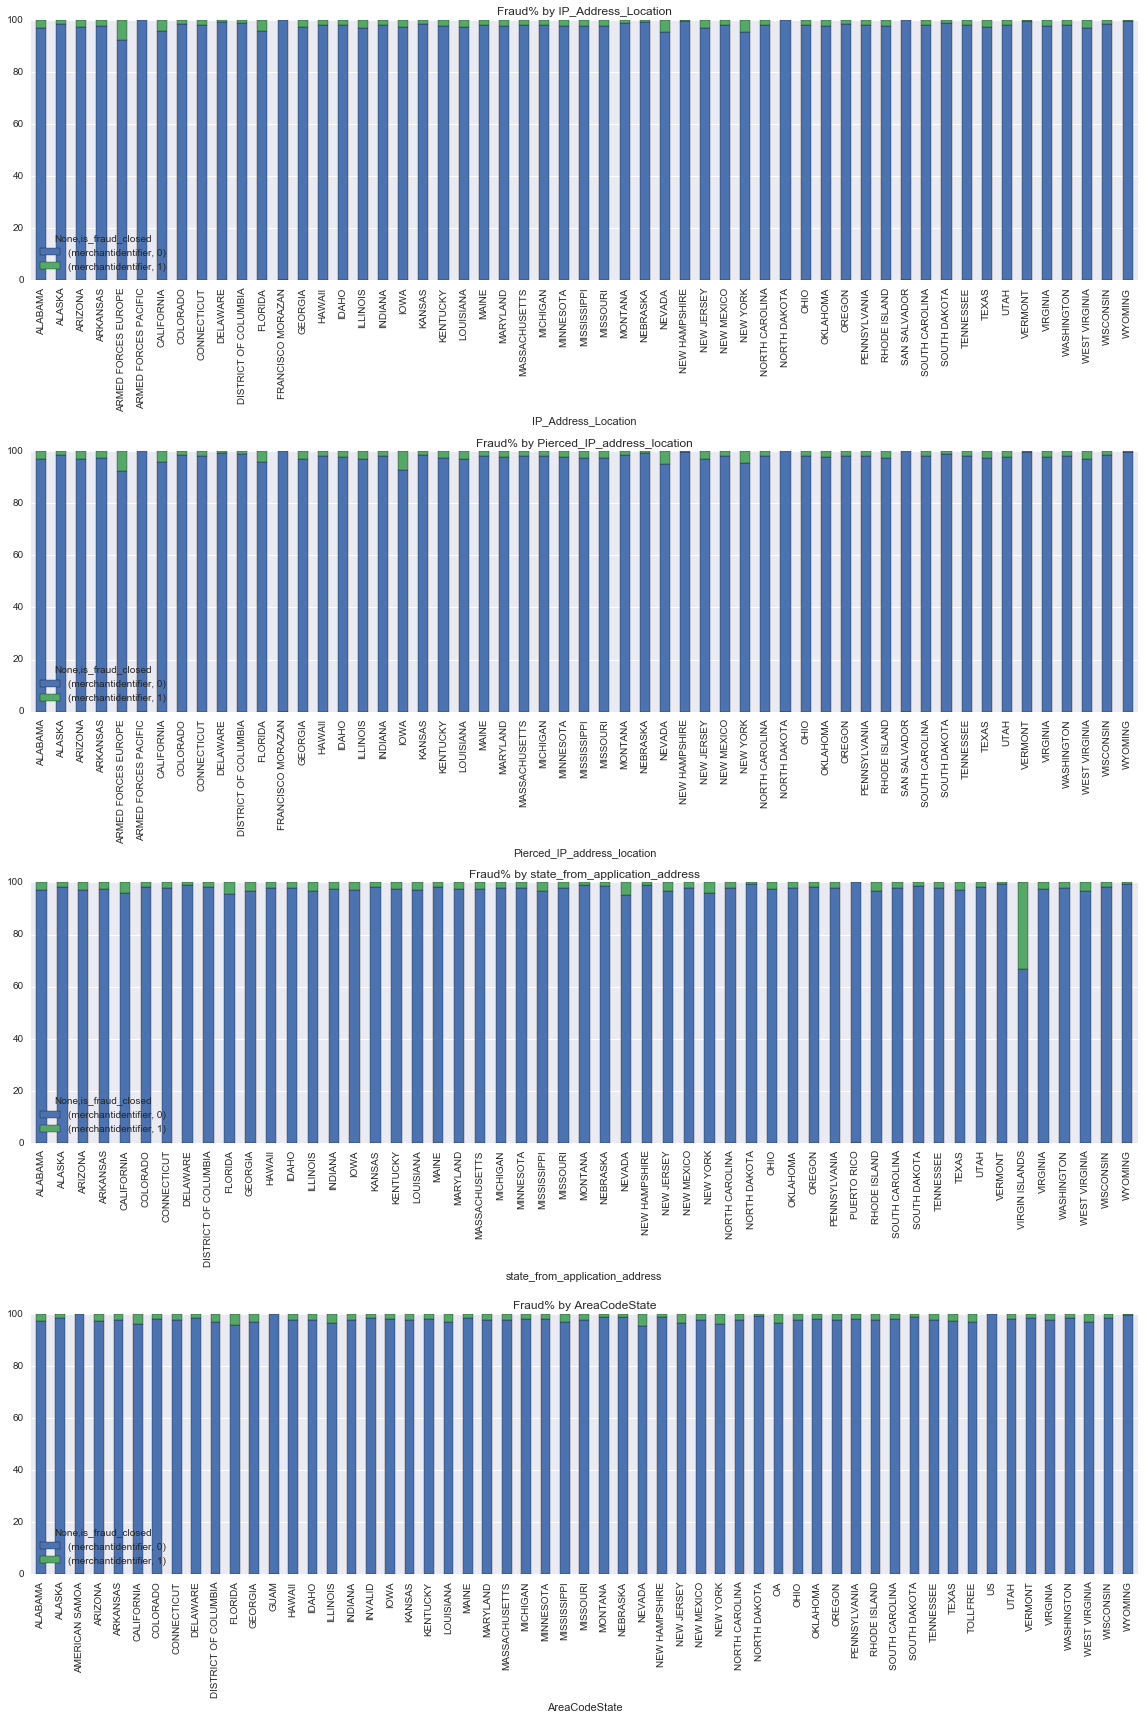

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#if Geographic matter for fraud
fig = plt.figure(figsize=(16, 24))

ax1 = plt.subplot("411")
ax1.set_title("Fraud% by IP_Address_Location")
var1 = fraud_data_train.groupby(['IP_Address_Location','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var1_pct = var1.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var1_pct.unstack().plot(kind='bar',stacked=True, ax = ax1)

ax2 = plt.subplot("412")
ax2.set_title("Fraud% by Pierced_IP_address_location")
var2 = fraud_data_train.groupby(['Pierced_IP_address_location','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var2_pct = var2.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var2_pct.unstack().plot(kind='bar',stacked=True, ax = ax2)

ax3 = plt.subplot("413")
ax3.set_title("Fraud% by state_from_application_address")
var3 = fraud_data_train.groupby(['state_from_application_address','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var3_pct = var3.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var3_pct.unstack().plot(kind='bar',stacked=True, ax = ax3)

ax4 = plt.subplot("414")
ax4.set_title("Fraud% by AreaCodeState")
var4 = fraud_data_train.groupby(["AreaCodeState",'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var4_pct = var4.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var4_pct.unstack().plot(kind='bar',stacked=True, ax = ax4)

fig.tight_layout()

plt.show()

Based on above chart, Geographic location matter in fraud distribution. 

Next we are going to take look at whether ip/piered ip matches address is matter for fraud. 

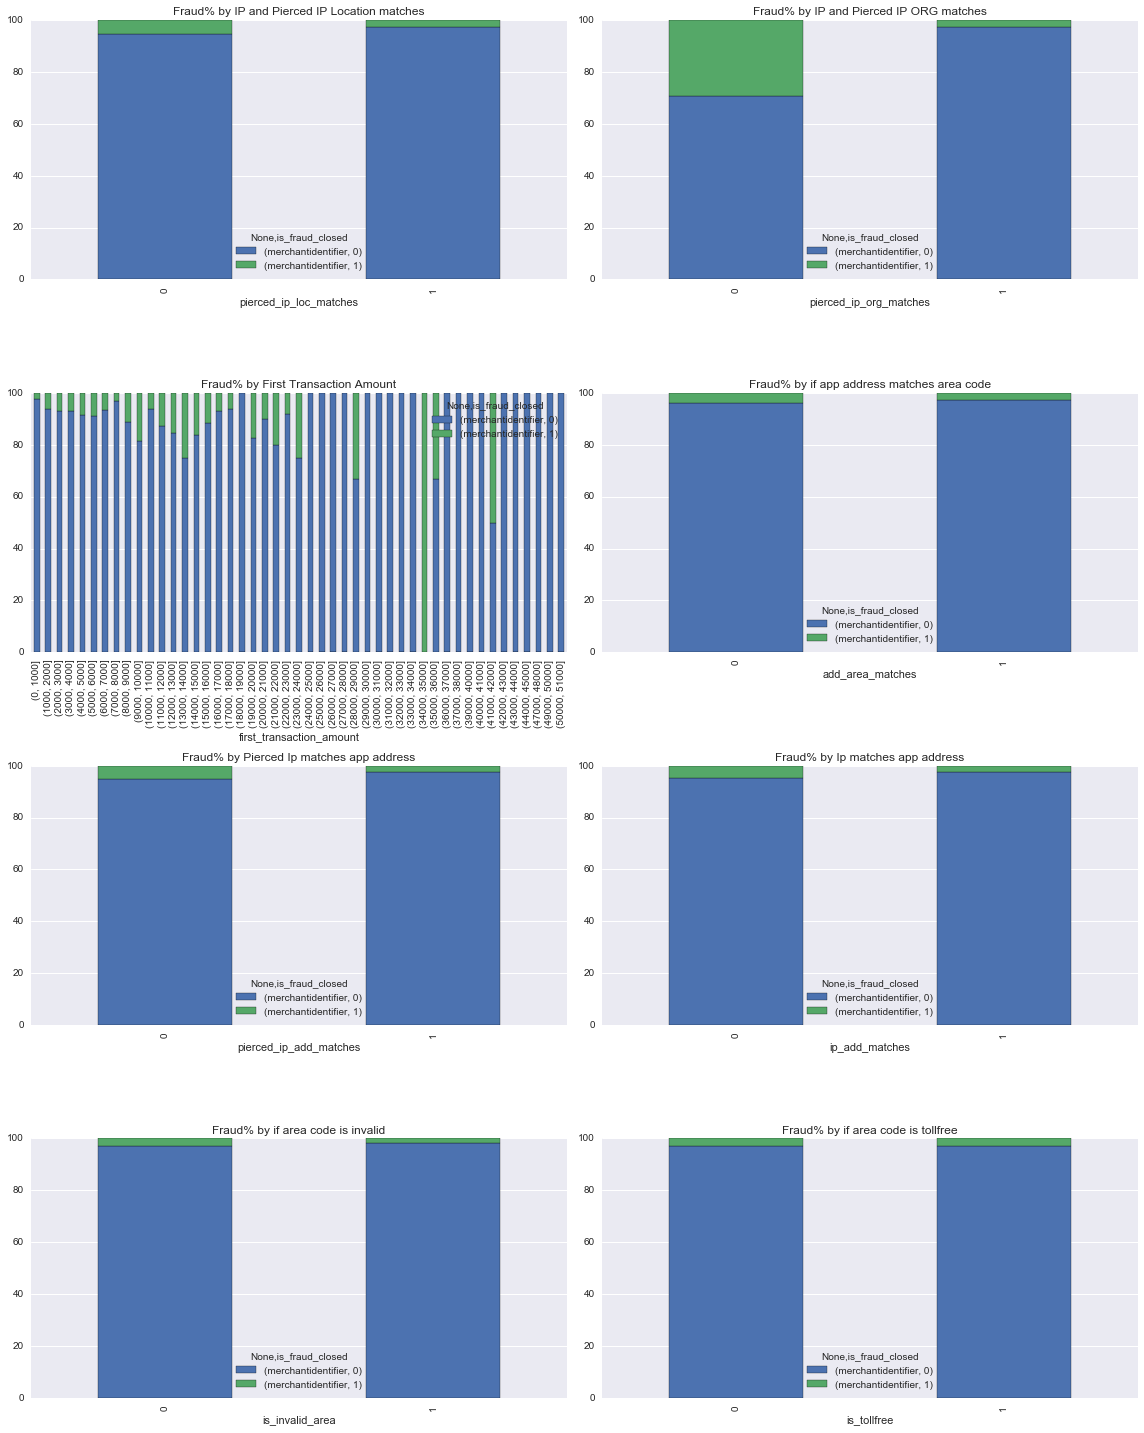

In [14]:
fig = plt.figure(figsize=(16, 20))
#fig.suptitle("Attributes Analysis", fontsize=16)

ax1 = plt.subplot("421")
ax1.set_title("Fraud% by IP and Pierced IP Location matches")
var1 = fraud_data_train.groupby(["pierced_ip_loc_matches",'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var1_pct = var1.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var1_pct.unstack().plot(kind='bar',stacked=True, ax = ax1)

ax2 = plt.subplot("422")
ax2.set_title("Fraud% by IP and Pierced IP ORG matches")
var2 = fraud_data_train.groupby(['pierced_ip_org_matches','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var2_pct = var2.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var2_pct.unstack().plot(kind='bar',stacked=True, ax = ax2)

ax3 = plt.subplot("423")
ax3.set_title("Fraud% by First Transaction Amount")
var3 = fraud_data_train.groupby([pd.cut(fraud_data_train["first_transaction_amount"], np.arange(0, 60000, 1000)),'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var3_pct = var3.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var3_pct.unstack().plot(kind='bar',stacked=True, ax = ax3)

ax4 = plt.subplot("424")
ax4.set_title("Fraud% by if app address matches area code")
var4 = fraud_data_train.groupby(['add_area_matches','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var4_pct = var4.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var4_pct.unstack().plot(kind='bar',stacked=True, ax = ax4)

ax5 = plt.subplot("425")
ax5.set_title("Fraud% by Pierced Ip matches app address")
var5 = fraud_data_train.groupby(['pierced_ip_add_matches','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var5_pct = var5.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var5_pct.unstack().plot(kind='bar',stacked=True, ax = ax5)


ax6 = plt.subplot("426")
ax6.set_title("Fraud% by Ip matches app address")
var6 = fraud_data_train.groupby(['ip_add_matches','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var6_pct = var6.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var6_pct.unstack().plot(kind='bar',stacked=True, ax = ax6)


ax7 = plt.subplot("427")
ax7.set_title("Fraud% by if area code is invalid")
var7 = fraud_data_train.groupby(["is_invalid_area",'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var7_pct = var7.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var7_pct.unstack().plot(kind='bar',stacked=True, ax = ax7)

ax8 = plt.subplot("428")
ax8.set_title("Fraud% by if area code is tollfree")
var8 = fraud_data_train.groupby(['is_tollfree','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var8_pct = var8.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var8_pct.unstack().plot(kind='bar',stacked=True, ax = ax8)

fig.tight_layout()

plt.show()



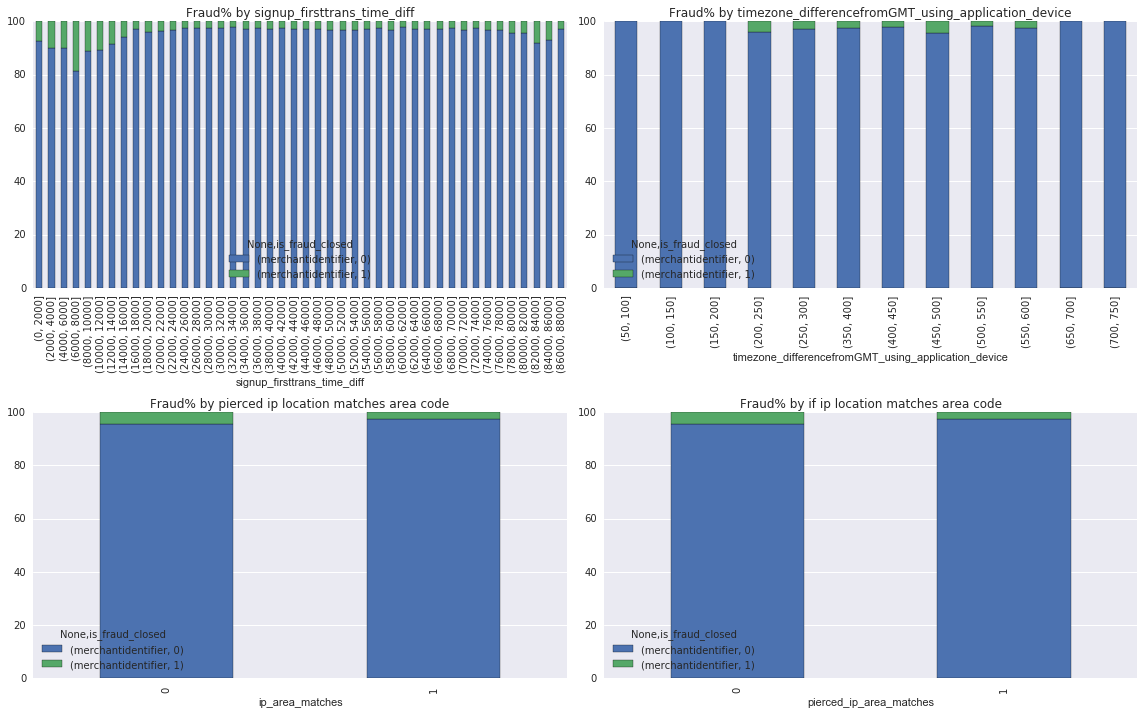

In [48]:
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot("221")
ax1.set_title("Fraud% by signup_firsttrans_time_diff")
var1 = fraud_data_train.groupby([pd.cut(fraud_data_train["signup_firsttrans_time_diff"], np.arange(0, 100000, 2000))
                                 ,'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var1_pct = var1.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var1_pct.unstack().plot(kind='bar',stacked=True,ax = ax1)

ax2 = plt.subplot("222")
ax2.set_title("Fraud% by timezone_differencefromGMT_using_application_device")
var2 = fraud_data_train.groupby([pd.cut(fraud_data_train["timezone_differencefromGMT_using_application_device"]
                                  , np.arange(0, 50000.0, 50.0))
                           ,'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var2_pct = var2.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var2_pct.unstack().plot(kind='bar',stacked=True, ax = ax2)

ax3 = plt.subplot("223")
ax3.set_title("Fraud% by pierced ip location matches area code")
var3 = fraud_data_train.groupby(['ip_area_matches','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var3_pct = var3.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var3_pct.unstack().plot(kind='bar',stacked=True, ax = ax3)

ax4 = plt.subplot("224")
ax4.set_title("Fraud% by if ip location matches area code")
var4 = fraud_data_train.groupby(['pierced_ip_area_matches','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var4_pct = var4.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var4_pct.unstack().plot(kind='bar',stacked=True, ax = ax4)

fig.tight_layout()

plt.show()

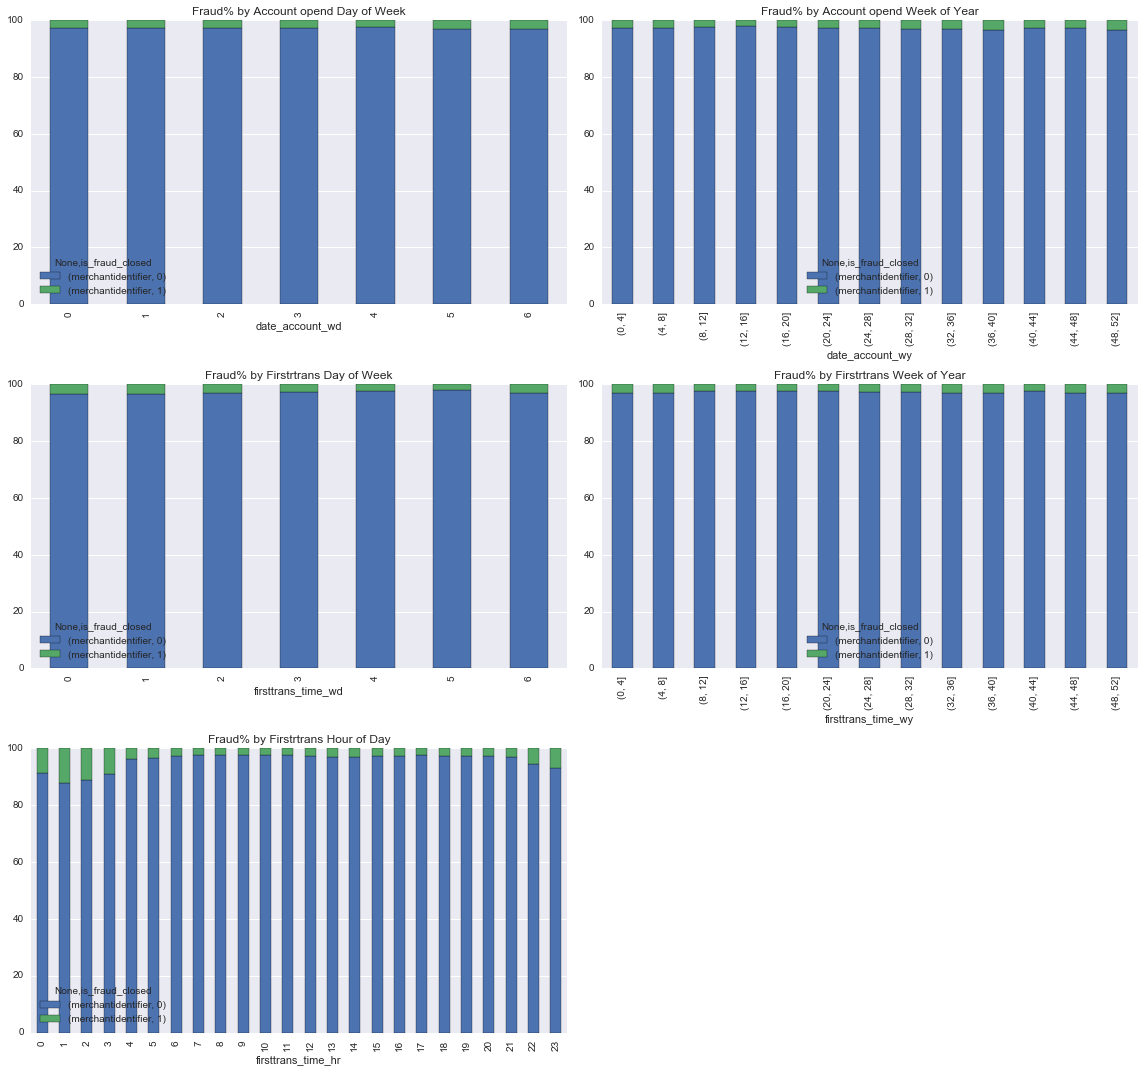

In [16]:
fig = plt.figure(figsize=(16, 15))

ax1 = plt.subplot("321")
ax1.set_title("Fraud% by Account opend Day of Week")
var1 = fraud_data_train.groupby(['date_account_wd','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var1_pct = var1.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var1_pct.unstack().plot(kind='bar',stacked=True, ax = ax1)

ax2 = plt.subplot("322")
ax2.set_title("Fraud% by Account opend Week of Year")
var2 = fraud_data_train.groupby([pd.cut(fraud_data_train["date_account_wy"], np.arange(0, 56, 4)),'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var2_pct = var2.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var2_pct.unstack().plot(kind='bar',stacked=True, ax = ax2)

ax3 = plt.subplot("323")
ax3.set_title("Fraud% by Firstrtrans Day of Week")
var3 = fraud_data_train.groupby(['firsttrans_time_wd','is_fraud_closed']).agg({'merchantidentifier': 'count'})
var3_pct = var3.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var3_pct.unstack().plot(kind='bar',stacked=True, ax = ax3)

ax4 = plt.subplot("324")
ax4.set_title("Fraud% by Firstrtrans Week of Year")
var4 = fraud_data_train.groupby([pd.cut(fraud_data_train["firsttrans_time_wy"], np.arange(0, 56, 4)),'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var4_pct = var4.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var4_pct.unstack().plot(kind='bar',stacked=True, ax = ax4)

ax5 = plt.subplot("325")
ax5.set_title("Fraud% by Firstrtrans Hour of Day")
var5 = fraud_data_train.groupby(["firsttrans_time_hr",'is_fraud_closed']).agg({'merchantidentifier': 'count'})
var5_pct = var5.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var5_pct.unstack().plot(kind='bar',stacked=True, ax = ax5)

fig.tight_layout()

plt.show()


Other day of week and week of year engineered features not seems matter in fraud risk. 

First trans by hour of day seems the only one matters in fraud distribution.

### Process Categorical variables and null value

I will drop useless variables like ip organization related variables and generated day of week and week of year variable.

Cause python sklearn naturally not accept Nan input, I will fill any Nan with variable mean. 

In [105]:

variable_drop_list = ['merchantidentifier', 'date_account_opened','first_transaction_time','dateclosedforfraud',
                      'is_fraud_closed','Pierced_IP_address_organization','IP_Address_organization',
                      'is_OA','date_account_wd','firsttrans_time_wd','date_account_wy','firsttrans_time_wy',
                      'Flag_for_data_with_fraud_outcomes'
                     ]
#Fill NAN data
for columns in fraud_data.columns:
    if fraud_data[columns].isnull().any().any():
        print columns
        
for column in fraud_data.columns:
    if fraud_data[column].isnull().any().any() and column not in variable_drop_list:
        if fraud_data[column].dtype != object and fraud_data[column].dtype != float:
            temp_value = int(fraud_data[column].mean(skipna=True, axis=0))
            fraud_data[column].fillna(temp_value, inplace=True)
            print 'none_float columns',column
        elif fraud_data[column].dtype == float:
            temp_value = fraud_data[column].mean(skipna=True, axis=0)        
            fraud_data[column].fillna(temp_value, inplace=True) 
            print 'float columns',column

print "Finish fill Nan data"

IP_Address_organization
IP_Address_Location
Pierced_IP_address_organization
Pierced_IP_address_location
timezone_differencefromGMT_using_application_device
dateclosedforfraud
float columns timezone_differencefromGMT_using_application_device
Finish fill Nan data


Python sklearn not like SAS/R, in tree-related algorithm, them can not handle categorical varaible, I will going to build dummy variable for each categorical value.

In [106]:
def preprocess_features(X,not_process):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object and col not in not_process:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

fraud_data = preprocess_features(fraud_data,variable_drop_list)
print "Processed feature columns ({} total features)".format(len(fraud_data.columns))

Processed feature columns (246 total features)


### Random shuffle and drop unuseful vaiables

In [107]:
# RANDOM SHUFFLE DATA
fraud_data_final = fraud_data.iloc[np.random.permutation(len(fraud_data))]
fraud_data_final.index = range(len(fraud_data_final))

fraud_data_preds_use= fraud_data[(fraud_data.date_account_opened>= 'July 10, 2015')]
fraud_data_train_final = fraud_data[(fraud_data_final.date_account_opened< 'July 10, 2015')]


target_preds_use = fraud_data_preds_use['is_fraud_closed']
target_preds_use = [np.int(x) for x in target_preds_use]

target_train_final = fraud_data_train_final['is_fraud_closed']
target_train_final = [np.int(x) for x in target_train_final]

merchant_id = fraud_data_preds_use['merchantidentifier']

#drop text and unuseful field
fraud_data_preds_use.drop(variable_drop_list,axis=1, inplace=True)
fraud_data_train_final.drop(variable_drop_list,axis=1, inplace=True)

print "finished pre-processing data"
print "If data still catain null:" , fraud_data_train_final.isnull().any().any()

for columns in fraud_data_preds_use.columns:
    if fraud_data_preds_use[columns].isnull().any().any():
        print 'contain NAN:',columns

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


finished pre-processing data
If data still catain null: False


In [108]:
display(fraud_data_train_final.head())

,IP_Address_Location_ALABAMA,IP_Address_Location_ALASKA,IP_Address_Location_ARIZONA,IP_Address_Location_ARKANSAS,IP_Address_Location_ARMED FORCES EUROPE,IP_Address_Location_ARMED FORCES PACIFIC,IP_Address_Location_CALIFORNIA,IP_Address_Location_COLORADO,IP_Address_Location_CONNECTICUT,IP_Address_Location_DELAWARE,...,pierced_ip_add_matches,ip_area_matches,pierced_ip_area_matches,pierced_ip_org_matches,pierced_ip_loc_matches,is_invalid_area,is_tollfree,signup_firsttrans_time_diff,date_account_hr,firsttrans_time_hr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,54983,0,15
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,20035,0,5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,42449,0,11
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,34799,0,9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,0,0,39726,0,11


## Modeling and parameter tunning

### Dealing with Unbalanced data

In [109]:
#deal with unbalanced data
from imblearn.over_sampling import RandomOverSampler
ro = RandomOverSampler()
X_resampled_full, y_resampled_full = ro.fit_sample(fraud_data_train_final, target_train_final)
X_resampled_full = pd.DataFrame(X_resampled_full,columns = fraud_data_train_final.columns)

print "resample unbalanced data finished"

resample unbalanced data finished


### Modele without Oversampling

In [111]:
#Random forest without imbalance data oversample
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score,mean_squared_error

randomforest = RandomForestClassifier(random_state=24,n_estimators=100,oob_score=True)
tree_score = make_scorer(f1_score, greater_is_better=True)

parameters = {'max_depth':[x for x in range(3,20)]}

clf_rf_noros = grid_search.GridSearchCV(estimator=randomforest, param_grid=parameters, cv=5, scoring=tree_score)

clf_rf_noros.fit(fraud_data_train_final,target_train_final)

print "Random Forest best parameter", clf_rf_noros.best_estimator_
print "Random Forest best score", clf_rf_noros.best_score_  
print "Random Forest Accuracy:", accuracy_score(target_train_final,clf_rf_noros.predict(fraud_data_train_final))  
print 'finish Random Forest Train'

 Random Forest best parameter RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=24, verbose=0, warm_start=False)
Random Forest best score 0.0196070170545
Random Forest Accuracy: 0.972113562741
finish Random Forest Train


### Modele with Oversampling
### Decision Tree
Let us start with decision tree. 

I will use cross validation to find the best depth of decision tree and what is the min_sample_split.
CV set to 5. 

And then I will build  a simplified decision tree with depth set to 3 to build the Part II SQL Query. 

In [81]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(fraud_data_train_final), n_folds=5)

fraud_data_train_final.index = range(len(fraud_data_train_final))
target_train_final = pd.DataFrame(target_train_final,columns = ['is_fraud_closed'])
target_train_final.index = range(len(target_train_final))

for max_depth in range(9, 10):
    print "running on max_depth:=", max_depth
    for min_samples_split in range(120,130,20):
        avg_f1_score = 0.0
        avg_accu_score = 0.0 
        for train, test in kf:
            X_train, X_test, Y_train, Y_test = fraud_data_train_final.iloc[train], fraud_data_train_final.iloc[test], target_train_final.iloc[train], target_train_final.iloc[test]
            X_resampled, y_resampled = ros.fit_sample(X_train, Y_train)           
            clf = DecisionTreeClassifier(random_state=24, 
                                         max_depth = max_depth,
                                         min_samples_split = min_samples_split
                                        )
            clf.fit(X_resampled, y_resampled)
            avg_f1_score += f1_score(Y_test,clf.predict(X_test))
            avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))   

        print "F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0 

        score_record = score_record.append(pd.DataFrame([[max_depth,min_samples_split,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                        columns=['max_depth', 'min_samples_split', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print "best max_depth", best_estimation.max_depth[0]
print "best min_samples_split", best_estimation.min_samples_split[0]
print "best f1 score", best_estimation.f1_score[0]
print "best accuracy_score", best_estimation.accuracy_score[0]


print('finished modeling')

best max_depth 9.0
best min_samples_split 120.0
best f1 score 0.107841208928
best accuracy_score 0.737951344665
finished modeling


In [84]:
clf_dt_full_best = DecisionTreeClassifier(max_depth=9, min_samples_split=120.0, random_state=24)
clf_dt_full_best.fit(X_resampled_full,y_resampled_full)

print "Decision Tree Full Grow F1 score on oversampled data", f1_score(y_resampled_full,clf_dt_full_best.predict(X_resampled_full))
print "Decision Tree Full Grow accuracy score on oversampled data",accuracy_score(y_resampled_full,clf_dt_full_best.predict(X_resampled_full))
print "Decision Tree Full Grow F1 score on original data",f1_score(target_train_final,clf_dt_full_best.predict(fraud_data_train_final))
print "Decision Tree Full Grow accuracy score on original data",accuracy_score(target_train_final,clf_dt_full_best.predict(fraud_data_train_final))

Decision Tree Full Grow F1 score on oversampled data 0.665541163011
Decision Tree Full Grow accuracy score on oversampled data 0.69312695592
Decision Tree Full Grow F1 score on original data 0.131200741771
Decision Tree Full Grow accuracy score on original data 0.770918648004


#### Simplied Decision Tree with max_depth = 3 

In [85]:
clf_dt_best = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                                          max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
                                          min_samples_split=400, min_weight_fraction_leaf=0.0,
                                          presort=False, random_state=24, splitter='best')
clf_dt_best.fit(X_resampled_full,y_resampled_full)
print "Decision Tree Simplified F1 score on undersampled data", f1_score(y_resampled_full,clf_dt_best.predict(X_resampled_full))
print "Decision Tree Simplified accuracy score on undersampled data",accuracy_score(y_resampled_full,clf_dt_best.predict(X_resampled_full))
print "Decision Tree Simplified F1 score on original data",f1_score(target_train_final,clf_dt_best.predict(fraud_data_train_final))
print "Decision Tree Simplified accuracy score on original data",accuracy_score(target_train_final,clf_dt_best.predict(fraud_data_train_final))

Decision Tree Simplified F1 score on undersampled data 0.626423631199
Decision Tree Simplified accuracy score on undersampled data 0.659807513878
Decision Tree Simplified F1 score on original data 0.112077192238
Decision Tree Simplified accuracy score on original data 0.744086547277


### Random Forest
Let's take look if random forest perform better

In [83]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

randomforest = RandomForestClassifier(random_state=24, n_estimators=100)

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(fraud_data_train_final), n_folds=5)

fraud_data_train_final.index = range(len(fraud_data_train_final))
target_train_final = pd.DataFrame(target_train_final,columns = ['is_fraud_closed'])
target_train_final.index = range(len(target_train_final))

for max_depth in range(3,31):
    print "running on max_depth:=", max_depth
    avg_f1_score = 0.0
    avg_accu_score = 0.0  
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = fraud_data_train_final.iloc[train], fraud_data_train_final.iloc[test], target_train_final.iloc[train], target_train_final.iloc[test]
        X_resampled, y_resampled = ros.fit_sample(X_train, Y_train)           
        clf = RandomForestClassifier(random_state=24, 
                                     n_estimators=100, 
                                     oob_score=True,
                                     max_depth = max_depth
                                    )
        clf.fit(X_resampled, y_resampled)
        avg_f1_score += f1_score(Y_test,clf.predict(X_test))
        avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))   

    print "F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0 
    score_record = score_record.append(pd.DataFrame([[max_depth,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                    columns=['max_depth', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print "best max_depth", best_estimation.max_depth[0]
print "best f1 score", best_estimation.f1_score[0]
print "best accuracy_score", best_estimation.accuracy_score[0]

print('finished modeling')

best max_depth 23.0
best f1 score 0.12463682924
best accuracy_score 0.871332493321
finished modeling


In [59]:
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score,mean_squared_error

clf_rf_best = RandomForestClassifier(max_depth=23, oob_score=True, random_state=24,n_estimators=100)
clf_rf_best.fit(X_resampled_full,y_resampled_full)
print "RandomForestClassifier F1 score on oversampled data", f1_score(y_resampled_full,clf_rf_best.predict(X_resampled_full))
print "RandomForestClassifier accuracy score on oversampled data",accuracy_score(y_resampled_full,clf_rf_best.predict(X_resampled_full))
print "RandomForestClassifier F1 score on original data",f1_score(target_train_final,clf_rf_best.predict(fraud_data_train_final))
print "RandomForestClassifier accuracy score on original data",accuracy_score(target_train_final,clf_rf_best.predict(fraud_data_train_final))

RandomForestClassifier F1 score on oversampled data 0.84100466999
RandomForestClassifier accuracy score on oversampled data 0.849282108541
RandomForestClassifier F1 score on original data 0.307884465262
RandomForestClassifier accuracy score on original data 0.898394046819


### ROC Curve

#### ROC Curve on Oversampled Data

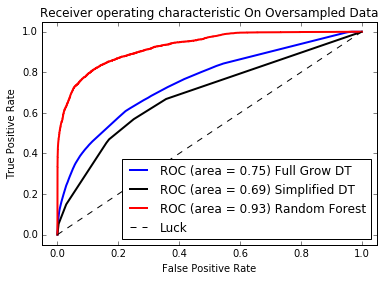

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score1 = clf_dt_full_best.predict_proba(X_resampled_full)#ROC for Full growed Decision Tree
y_score2 = clf_dt_best.predict_proba(X_resampled_full)#ROC for Simplified Decision Tree
y_score3 = clf_rf_best.predict_proba(X_resampled_full)#ROC for Random Frorest

# Compute ROC curve and ROC area for each class
fpr1, tpr1, thresholds1 = roc_curve(y_resampled_full, y_score1[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(y_resampled_full, y_score2[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(y_resampled_full, y_score3[:, 1])

# Compute micro-average ROC curve and ROC area
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(fpr1, tpr1, lw=2, color='blue',
         label='ROC (area = %0.2f) Full Grow DT' %  roc_auc1)
plt.plot(fpr2, tpr2, lw=2, color='black',
         label='ROC (area = %0.2f) Simplified DT' %  roc_auc2)    
plt.plot(fpr3, tpr3, lw=2, color='red',
         label='ROC (area = %0.2f) Random Forest' %  roc_auc3)    
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k',
         label='Luck')
    
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic On Oversampled Data')
plt.legend(loc="lower right")
plt.show()


#### ROC Curve on Original Data

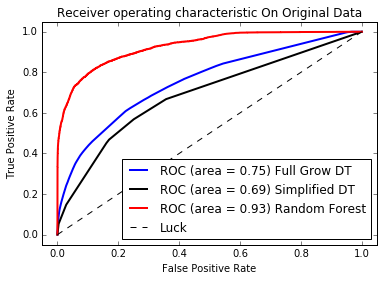

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score1 = clf_dt_full_best.predict_proba(fraud_data_train_final)#ROC for Full growed Decision Tree
y_score2 = clf_dt_best.predict_proba(fraud_data_train_final)#ROC for Simplified Decision Tree
y_score3 = clf_rf_best.predict_proba(fraud_data_train_final)#ROC for Random Frorest

# Compute ROC curve and ROC area for each class
fpr1, tpr1, thresholds1 = roc_curve(target_train_final, y_score1[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(target_train_final, y_score2[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(target_train_final, y_score3[:, 1])

# Compute micro-average ROC curve and ROC area
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(fpr1, tpr1, lw=2, color='blue',
         label='ROC (area = %0.2f) Full Grow DT' %  roc_auc1)
plt.plot(fpr2, tpr2, lw=2, color='black',
         label='ROC (area = %0.2f) Simplified DT' %  roc_auc2)    
plt.plot(fpr3, tpr3, lw=2, color='red',
         label='ROC (area = %0.2f) Random Forest' %  roc_auc3)    
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k',
         label='Luck')
    
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic On Original Data')
plt.legend(loc="lower right")
plt.show()

### Predict The risky Merchant using best model. 

Based on model performance(F1 score) and ROC Curve (Decision Tree/Simplified Decision Tree/Random Forest). I will use Random Forest for future risk indicator predication. Note: Random Forest performance are better than decision tree, so I just use random forest and it also have more smooth curves in ROC Chart. 

Based on above Random Forest ROC curve, we can choose a small cutoff to prevent high false positive rate.  
use Pathagoras' theorem this distance is sqrt( (1-sensitivity)²+(1-specificity)² ), and we want the shortest one. 

In [62]:
rf_roc = pd.DataFrame(fpr3,columns=['FPR'])
rf_roc['TPR'] = tpr3
rf_roc['Threshold'] = thresholds3

rf_roc['distance'] = rf_roc['FPR']**2 + (1.0- rf_roc['TPR'])**2

min_value = rf_roc['distance'].min()

print "best cut off point"
display(rf_roc[rf_roc.distance == min_value])

best cut off point


,FPR,TPR,Threshold,distance
6316,0.142926,0.842318,0.461118,0.045291


The best cutoff threshold is almost matching the build in random forest cutoff (0.5). No furthur adjustment require

#### Run Best Model

In [63]:
# Prediction
predicted_value = pd.DataFrame(clf_rf_best.predict_proba(fraud_data_preds_use)[:,1], columns=['fraud_risk'])
merchant_id.index = range(len(merchant_id))
predicted_value_pd = pd.concat([merchant_id, predicted_value], axis=1)

print 'finish predication'

finish predication


In [64]:
print "Predict as fraud",clf_rf_best.predict(fraud_data_preds_use).sum()
print "#Merchant in Data to predict",len(clf_rf_best.predict(fraud_data_preds_use))
print "Model recognize as fraud",clf_rf_best.predict(fraud_data_train_final).sum()
print "#Merchant in Data in train",len(clf_rf_best.predict(fraud_data_train_final))

Predict as fraud 211
#Merchant in Data to predict 1664
Model recognize as fraud 15505
#Merchant in Data in train 130888


#### Generate Output File

In [65]:
#  OUTPUT TO CSV

predicted_value_sorted = predicted_value_pd.sort_values(by = ['fraud_risk'],ascending=False)
top_100 = predicted_value_sorted.head(100)

predicted_value_pd.to_csv('../output/full_predications.csv', index=False)
top_100.to_csv('../output/top100_risk.csv', index=False)

print 'output finish'

output finish


## Part II

### Visualization Simplified Decision Tree

In [49]:
#export and visualization decision path
from sklearn.tree import export_graphviz

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

visualize_tree(clf_dt_best, X_resampled.columns)

print 'Finish visualization tree'

Finish visualization tree


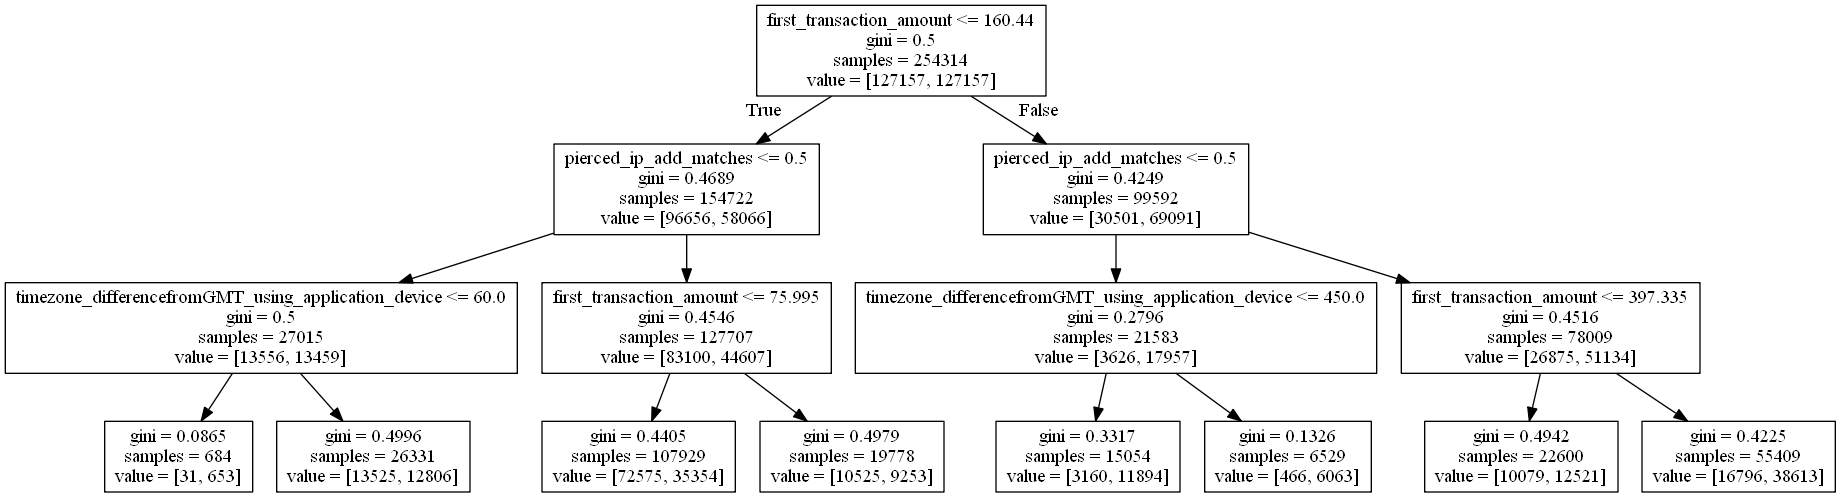

In [51]:
from IPython.display import Image
Image("dt.png")

### Extract Decision Tree Logic and convert to SQL Query

#### Extract Decision Tree Logic

In [52]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + str(value[node])

        recurse(left, right, threshold, features, 0)

get_code(clf_dt_best, X_resampled.columns)

if ( first_transaction_amount <= 160.440002441 ) {
if ( pierced_ip_add_matches <= 0.5 ) {
if ( timezone_differencefromGMT_using_application_device <= 60.0 ) {
return [[  31.  653.]]
} else {
return [[ 13525.  12806.]]
}
} else {
if ( first_transaction_amount <= 75.9949951172 ) {
return [[ 72575.  35354.]]
} else {
return [[ 10525.   9253.]]
}
}
} else {
if ( pierced_ip_add_matches <= 0.5 ) {
if ( timezone_differencefromGMT_using_application_device <= 450.0 ) {
return [[  3160.  11894.]]
} else {
return [[  466.  6063.]]
}
} else {
if ( first_transaction_amount <= 397.334991455 ) {
return [[ 10079.  12521.]]
} else {
return [[ 16796.  38613.]]
}
}
}


#### Convert to SQL Query

*Note: Since I convert state_from_application_address to use full state name in feature engineering part. *

*Let us assume state_from_application_address is using full state name here. *

In [ ]:
Select merchantidentifier,
       case 
            when first_transaction_amount <= 160.440002441
            and  state_from_application_address != Pierced_IP_address_location
            and  timezone_differencefromGMT_using_application_device <= 60.0
            then 1
                             
            when first_transaction_amount <= 160.440002441
            and  state_from_application_address = Pierced_IP_address_location
            and  first_transaction_amount <= 75.9949951172
            then 1
            
            when first_transaction_amount > 160.440002441
            and  state_from_application_address != Pierced_IP_address_location
            and  timezone_differencefromGMT_using_application_device <= 450.0
            then 1
            
            when first_transaction_amount > 160.440002441
            and  state_from_application_address = Pierced_IP_address_location
            and  first_transaction_amount <= 397.334991455
            then 1
            
            else 0
       end as Fraud_risk_flag
from merchant_table

## End

## Appendix

### Oversampling use SMOTE

In [118]:
#RANDOM FOREST USING SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
smotes = SMOTE()

randomforest = RandomForestClassifier(random_state=24, n_estimators=100)

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(fraud_data_train_final), n_folds=5)

target_train_final_smote = pd.DataFrame(target_train_final,columns = ['class'])
target_train_final_smote.index = range(len(target_train_final_smote))

for max_depth in range(3,8,1):
    print "running on max_depth:=", max_depth
    avg_f1_score = 0.0
    avg_accu_score = 0.0    
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = fraud_data_train_final.iloc[train], fraud_data_train_final.iloc[test], target_train_final_smote.iloc[train], target_train_final_smote.iloc[test]
        X_resampled, y_resampled = smotes.fit_sample(X_train, Y_train)           
        clf = RandomForestClassifier(random_state=24, 
                                     n_estimators=100, 
                                     max_depth = max_depth
                                    )
        clf.fit(X_resampled, y_resampled)
        avg_f1_score += f1_score(Y_test,clf.predict(X_test))
        avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))    
    print "F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0                           
    score_record = score_record.append(pd.DataFrame([[max_depth,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                    columns=['max_depth', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print "best Out Of BAG max_depth", best_estimation.max_depth[0]
print "best Out Of BAG f1 score", best_estimation.f1_score[0]
print "best Out Of BAG accuracy_score", best_estimation.accuracy_score[0]

print('finished modeling')

best Out Of BAG max_depth 5.0
best Out Of BAG f1 score 0.117097689528
best Out Of BAG accuracy_score 0.939803573907
finished modeling


In [122]:
#deal with unbalanced data
from imblearn.over_sampling import SMOTE
smotes = SMOTE()
X_resampled_smote, y_resampled_smote = smotes.fit_sample(fraud_data_train_final, target_train_final)
X_resampled_smote = pd.DataFrame(X_resampled_smote,columns = fraud_data_train_final.columns)

print "resample unbalanced data finished"

from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score,mean_squared_error

clf_rf_smote = RandomForestClassifier(max_depth=5, oob_score=True, random_state=24,n_estimators=100)
clf_rf_smote.fit(X_resampled_smote,y_resampled_smote)

print "RandomForestClassifier F1 score on oversampled data", f1_score(y_resampled_smote,clf_rf_smote.predict(X_resampled_smote))
print "RandomForestClassifier accuracy score on oversampled data",accuracy_score(y_resampled_smote,clf_rf_smote.predict(X_resampled_smote))
print "RandomForestClassifier F1 score on original data",f1_score(target_train_final,clf_rf_smote.predict(fraud_data_train_final))
print "RandomForestClassifier accuracy score on original data",accuracy_score(target_train_final,clf_rf_smote.predict(fraud_data_train_final))

resample unbalanced data finished
RandomForestClassifier F1 score on oversampled data 0.869724221904
RandomForestClassifier accuracy score on oversampled data 0.880108359742
RandomForestClassifier F1 score on original data 0.12348565356
RandomForestClassifier accuracy score on original data 0.936984291914


### Oversampling/Undersampling Combine

In [120]:
#RANDOM FOREST USING RANDOM OVER SAMPLING WITH 
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.combine import SMOTEENN
smoteenns = SMOTEENN()

randomforest = RandomForestClassifier(random_state=24, n_estimators=100)

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(fraud_data_train_final), n_folds=5)

target_train_final_smote = pd.DataFrame(target_train_final,columns = ['class'])
target_train_final_smote.index = range(len(target_train_final_smote))

for max_depth in range(3,8,1):
    print "running on max_depth:=", max_depth
    avg_f1_score = 0.0
    avg_accu_score = 0.0    
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = fraud_data_train_final.iloc[train], fraud_data_train_final.iloc[test], target_train_final_smote.iloc[train], target_train_final_smote.iloc[test]
        X_resampled, y_resampled = smoteenns.fit_sample(X_train, Y_train)           
        clf = RandomForestClassifier(random_state=24, 
                                     n_estimators=100, 
                                     max_depth = max_depth
                                    )
        clf.fit(X_resampled, y_resampled)
        avg_f1_score += f1_score(Y_test,clf.predict(X_test))
        avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))    
    print "F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0                           
    score_record = score_record.append(pd.DataFrame([[max_depth,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                    columns=['max_depth', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print "best Out Of BAG max_depth", best_estimation.max_depth[0]
print "best Out Of BAG f1 score", best_estimation.f1_score[0]
print "best Out Of BAG accuracy_score", best_estimation.accuracy_score[0]

print('finished modeling')

best Out Of BAG max_depth 5.0
best Out Of BAG f1 score 0.122291241362
best Out Of BAG accuracy_score 0.958338461522
finished modeling


In [124]:
#deal with unbalanced data
from imblearn.combine import SMOTEENN
smoteenns = SMOTEENN()

X_resampled_smoteenns, y_resampled_smoteenns = smoteenns.fit_sample(fraud_data_train_final, target_train_final)
X_resampled_smoteenns = pd.DataFrame(X_resampled_smoteenns,columns = fraud_data_train_final.columns)

print "resample unbalanced data finished"

from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score,mean_squared_error

clf_rf_smoteenn = RandomForestClassifier(max_depth=5, oob_score=True, random_state=24,n_estimators=100)
clf_rf_smoteenn.fit(X_resampled_smoteenns,y_resampled_smoteenns)
print "RandomForestClassifier F1 score on oversampled data", f1_score(y_resampled_smoteenns,clf_rf_smoteenn.predict(X_resampled_smoteenns))
print "RandomForestClassifier accuracy score on oversampled data",accuracy_score(y_resampled_smoteenns,clf_rf_smoteenn.predict(X_resampled_smoteenns))
print "RandomForestClassifier F1 score on original data",f1_score(target_train_final,clf_rf_smoteenn.predict(fraud_data_train_final))
print "RandomForestClassifier accuracy score on original data",accuracy_score(target_train_final,clf_rf_smoteenn.predict(fraud_data_train_final))

resample unbalanced data finished
RandomForestClassifier F1 score on oversampled data 0.852162757621
RandomForestClassifier accuracy score on oversampled data 0.883968322761
RandomForestClassifier F1 score on original data 0.1266620014
RandomForestClassifier accuracy score on original data 0.961860521973


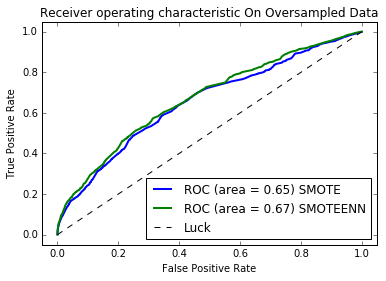

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score1 = clf_rf_smote.predict_proba(fraud_data_train_final)#ROC for RF with SMOTE
y_score2 = clf_rf_smoteenn.predict_proba(fraud_data_train_final)#ROC for RF with SMOTEENN

# Compute ROC curve and ROC area for each class
fpr1, tpr1, thresholds1 = roc_curve(target_train_final, y_score1[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(target_train_final, y_score2[:, 1])


# Compute micro-average ROC curve and ROC area
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr1, tpr1, lw=2, 
         label='ROC (area = %0.2f) SMOTE' %  roc_auc1)
plt.plot(fpr2, tpr2, lw=2, 
         label='ROC (area = %0.2f) SMOTEENN' %  roc_auc2)    
  
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k',
         label='Luck')
    
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic On Oversampled Data')
plt.legend(loc="lower right")
plt.show()